In [1]:
import os
import json
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
#from catboost import CatBoostClassifier, Pool, cv
import statsmodels.api as sm

In [3]:
os.chdir('..')
os.chdir('..')
os.chdir('..')

In [4]:
pwd

'D:\\coding\\springboard\\capstone\\springboard-capstone-project\\app'

### Data wrangling for supervised models

In [1]:
nyt = pd.read_csv('data/nyt/data_clean.csv').reset_index()
nyt_label = pd.read_csv('data/nyt/nyt_group1_labelled.csv')

NameError: name 'pd' is not defined

In [ ]:
nyt['headline'] = nyt.headline.str.replace("â\x80\x99","'").str.replace("â\x80\x98", "'")
nyt['snippet'] = nyt.snippet.str.replace("â\x80\x99","'").str.replace("â\x80\x98", "'")
nyt['text'] = nyt.headline.fillna('') + '. ' + nyt.snippet.fillna('')

In [6]:
with open("data/nyt/word_index.json",) as f:
    word_index = json.load(f)
word_index_r = {v: k for k, v in word_index.items()}

In [7]:
nyt.head(2)

,index,web_url,pub_date,organizations,subjects,headline,snippet,text,text_clean
0,0,https://www.nytimes.com/2001/07/12/business/ad...,2001-07-12T05:00:00+0000,Young &,TELEVISION AND RADIO PROGRAMMING | Stocks and ...,Addenda: Whitehall Parts Ways With Young & Rub...,The Whitehall-Robins Healthcare division of th...,Addenda: Whitehall Parts Ways With Young & Rub...,addenda whitehall part way young rubicam white...
1,1,https://www.nytimes.com/2001/07/15/business/a-...,2001-07-15T05:00:00+0000,"Portland State University,Nike Incorporated,Fo...",NaN,A Famous $35 Emblem Put to Charitable Use,"In 1971, Philip H. Knight asked Carolyn Davids...",A Famous $35 Emblem Put to Charitable Use In 1...,famous emblem put charitable use philip h knig...


In [8]:
nyt_label.head()

,web_url,label
0,https://www.nytimes.com/2001/07/29/business/le...,S
1,https://www.nytimes.com/2001/08/16/business/me...,O
2,https://www.nytimes.com/2001/08/31/business/gr...,O
3,https://www.nytimes.com/2001/09/17/business/fe...,O
4,https://www.nytimes.com/2001/10/07/business/ne...,O


In [9]:
nyt_enc.iloc[:5]

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1,1,144,102,566,1,1,1,684,65,...,67,349,566,1,314,144,566,1,0,0
1,2782,1,185,1,33,1,1259,1,348,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,4,67,1084,1,1,1,1,255,...,0,0,0,0,0,0,0,0,0,0
3,1,1887,2064,147,1789,4,173,1,1887,2064,...,0,0,0,0,0,0,0,0,0,0
4,1,687,578,651,217,1,1,92,32,1,...,2117,1107,687,376,117,2,1,0,0,0


In [10]:
nyt.shape

(80119, 9)

In [11]:
nyt_enc.shape

(80119, 30)

In [12]:
word_index_r[1], word_index_r[2]

('<UNK>', 'say')

In [13]:
nyt_melt = nyt_enc.iloc[:, 1:].reset_index().melt(id_vars='index')
nyt_melt['count'] = 1
nyt_bow = nyt_melt.pivot_table(index='index', columns='value', values='count', aggfunc=sum).fillna(0)

In [14]:
nyt_bow

value,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
index,,,,,,,,,,,,,,,,,,,,,
0,2.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,12.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10.0,7.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,16.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80114,17.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80115,7.0,7.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
80116,3.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


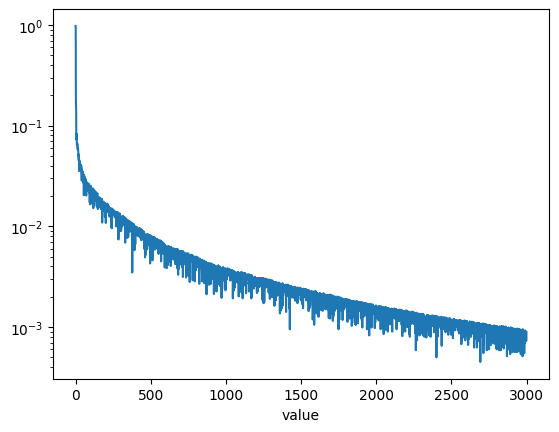

In [15]:
df_plot_mean = (nyt_bow > 0).mean(axis=0)
df_plot_mean.plot()
plt.yscale('log')
plt.show()

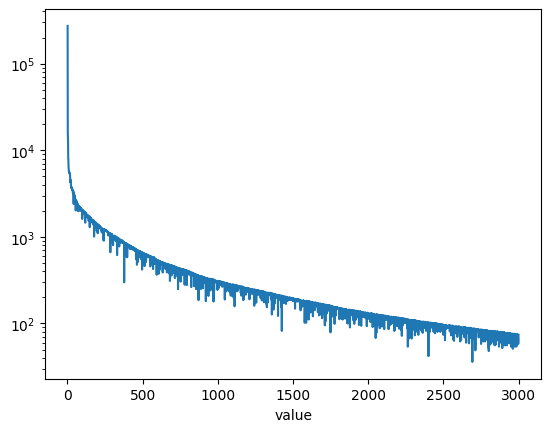

In [16]:
df_plot_sum = nyt_bow.iloc[:, 1:].sum(axis=0)
df_plot_sum.plot()
plt.yscale('log')
plt.show();

In [17]:
pd.Series(df_plot_mean[df_plot_mean >= 0.1].index.map(word_index_r))

0        NaN
1      <UNK>
2        say
3    company
4        new
Name: value, dtype: object

In [18]:
nyt.shape

(80119, 9)

In [19]:
nyt = nyt.merge(nyt_label, how='inner', left_on='web_url', right_on='web_url')

In [20]:
nyt.shape

(1005, 10)

In [21]:
nyt.label.value_counts()

O      538
G      217
S      171
SG      35
E       27
ES      12
EG       3
ESG      2
Name: label, dtype: int64

In [22]:
nyt_enc.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1,1,144,102,566,1,1,1,684,65,...,67,349,566,1,314,144,566,1,0,0
1,2782,1,185,1,33,1,1259,1,348,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,4,67,1084,1,1,1,1,255,...,0,0,0,0,0,0,0,0,0,0
3,1,1887,2064,147,1789,4,173,1,1887,2064,...,0,0,0,0,0,0,0,0,0,0
4,1,687,578,651,217,1,1,92,32,1,...,2117,1107,687,376,117,2,1,0,0,0


In [23]:
Xy = nyt_bow.merge(nyt[['index', 'label']], how='inner', left_index=True, right_on='index').drop(columns=['index'])

In [24]:
Xy.head()

,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,label
0,12.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,S
1,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O
2,7.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O
3,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O
4,0.0,3.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,O


In [25]:
X = Xy.iloc[:, :-1]
y = Xy.iloc[:, -1]

In [26]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,12.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,2.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
Y = pd.DataFrame(y)
Y['E'] = Y['label'].map(lambda x: 1 if 'E' in x else 0)
Y['S'] = Y['label'].map(lambda x: 1 if 'S' in x else 0)
Y['G'] = Y['label'].map(lambda x: 1 if 'G' in x else 0)
Y['O'] = Y['label'].map(lambda x: 1 if 'O' in x else 0)

In [28]:
Y.head()

,label,E,S,G,O
0,S,0,1,0,0
1,O,0,0,0,1
2,O,0,0,0,1
3,O,0,0,0,1
4,O,0,0,0,1


In [29]:
Y.drop(columns='label', inplace=True)

In [30]:
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.25)

In [31]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, stratify=Y_train_val, test_size=0.25)

In [32]:
X_train.shape

(564, 2999)

In [33]:
X_val.shape

(189, 2999)

In [34]:
X_test.shape

(252, 2999)

In [35]:
Y_train.sum()/Y_train.shape[0]

E    0.044326
S    0.219858
G    0.255319
O    0.535461
dtype: float64

In [36]:
Y_val.sum()/Y_val.shape[0]

E    0.042328
S    0.216931
G    0.259259
O    0.534392
dtype: float64

In [37]:
Y_test.sum()/Y_test.shape[0]

E    0.043651
S    0.218254
G    0.253968
O    0.535714
dtype: float64

In [38]:
tfidf = TfidfTransformer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_train_val_tfidf = tfidf.transform(X_train_val)
X_test_tfidf = tfidf.transform(X_test)

In [127]:
def cross_validate_wrapper(model, X, y, scoring):
    cv_results = cross_validate(model,
                            X,
                            y,
                            cv=5,
                            scoring=scoring,
                            n_jobs=-1,
                            verbose=0)
    
    stats = {}
    for score_metric in scoring:
        score_key = f'test_{score_metric}'
        mu = cv_results[score_key].mean()
        sigma = cv_results[score_key].std()
        stats[score_metric] = (mu, sigma)

    stats = pd.DataFrame(stats, index=['mean', 'stdev']).T
    
    return stats, cv_results

In [137]:
def fit_cv_best(model, param_grid, X_train, y_train, scoring_fit, scorings_assess, verbose=0):
    model_gs = GridSearchCV(model,
                       param_grid=param_grid,
                       scoring=scoring_fit,
                       cv=5,
                       n_jobs=-1,
                       verbose=verbose)

    model_gs.fit(X_train, y_train)

    model_stats, _ = cross_validate_wrapper(model_gs, X_train, y_train, scorings_assess)

    return model_gs, model_stats

In [175]:
def fit_ESG(model, param_grid, X_train, y_train, scoring_fit, scoring_assess):
    res = {}
    for col in ['E', 'S', 'G']:
        print(col)
        y_train = Y_train[col]
        y_train_val = Y_train_val[col]
        y_val = Y_val[col]
        y_test = Y_test[col]
        model_gs, model_stats = fit_cv_best(model, param_grid, X_train, y_train, scoring_fit, scorings_assess)
        res[col] = {'model_gs': model_gs, 'model_stats': model_stats}
        
    res_E = res['E']['model_stats'].rename(columns={'mean': 'mean_E', 'stdev': 'stdev_E'})
    res_S = res['S']['model_stats'].rename(columns={'mean': 'mean_S', 'stdev': 'stdev_S'})
    res_G = res['G']['model_stats'].rename(columns={'mean': 'mean_G', 'stdev': 'stdev_G'})
    res['stats'] = pd.concat((res_E, res_S, res_G), axis=1)
    
    return res

In [163]:
scoring_fit = 'f1'
scorings_assess = ['accuracy', 'roc_auc', 'precision', 'recall', 'f1']

In [199]:
param_grid = [{'penalty' : ['l1', 'l2'], 
               'class_weight': ['balanced', None],
               'C' : np.logspace(-1, 3, 5), 
               'solver' : ['liblinear']}]

lr = LogisticRegression(random_state=0)

res_lr = fit_ESG(lr, param_grid, X_train, y_train, scoring_fit, scorings_assess)

E
S
G


In [200]:
res_lr['E']['model_gs'].best_params_, res_lr['S']['model_gs'].best_params_, res_lr['G']['model_gs'].best_params_

({'C': 1000.0,
  'class_weight': 'balanced',
  'penalty': 'l1',
  'solver': 'liblinear'},
 {'C': 10.0,
  'class_weight': 'balanced',
  'penalty': 'l1',
  'solver': 'liblinear'},
 {'C': 10.0,
  'class_weight': 'balanced',
  'penalty': 'l2',
  'solver': 'liblinear'})

In [201]:
res_lr['stats']

,mean_E,stdev_E,mean_S,stdev_S,mean_G,stdev_G
accuracy,0.909450,0.044658,0.700474,0.146872,0.792525,0.012486
roc_auc,0.668060,0.089838,0.636542,0.133888,0.734817,0.047273
precision,0.044103,0.060643,0.416047,0.113466,0.625990,0.044760
recall,0.120000,0.160000,0.353667,0.120335,0.478079,0.097284
f1,0.064444,0.087883,0.351602,0.063474,0.534976,0.064701


In [207]:
param_grid = [{'kernel': ['rbf'],
               'gamma': [1e-3, 1e-4],
               'C': [1, 10],
               'class_weight': ['balanced', None]},
              {'kernel': ['linear'], 
               'C': [1, 10],
               'class_weight': ['balanced', None]}]

svm = SVC(probability=True)

res_sv = fit_ESG(svm, param_grid, X_train, y_train, scoring_fit, scorings_assess)

E
S
G


In [208]:
res_sv['E']['model_gs'].best_params_, res_sv['S']['model_gs'].best_params_, res_sv['G']['model_gs'].best_params_

({'C': 10, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'},
 {'C': 10, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'})

In [209]:
res_sv['stats']

,mean_E,stdev_E,mean_S,stdev_S,mean_G,stdev_G
accuracy,0.790755,0.027947,0.641798,0.032471,0.695070,0.105447
roc_auc,0.601582,0.085819,0.666269,0.026106,0.700748,0.049584
precision,0.074151,0.022529,0.322961,0.031588,0.478225,0.135081
recall,0.320000,0.097980,0.572667,0.089154,0.540394,0.142428
f1,0.120021,0.036088,0.411074,0.044553,0.480389,0.070815


In [210]:
param_grid = {'n_estimators': np.linspace(10, 50, 5).astype('int'),
              'max_depth': np.linspace(20, 100, 9),
              'min_samples_leaf': [1, 2, 5],
              'class_weight': ['balanced', None]}

rf = RandomForestClassifier()

res_rf = fit_ESG(rf, param_grid, X_train, y_train, scoring_fit, scorings_assess)

E
S
G


In [211]:
res_rf['E']['model_gs'].best_params_, res_rf['S']['model_gs'].best_params_, res_rf['G']['model_gs'].best_params_

({'class_weight': 'balanced',
  'max_depth': 100.0,
  'min_samples_leaf': 5,
  'n_estimators': 10},
 {'class_weight': 'balanced',
  'max_depth': 90.0,
  'min_samples_leaf': 5,
  'n_estimators': 30},
 {'class_weight': 'balanced',
  'max_depth': 40.0,
  'min_samples_leaf': 5,
  'n_estimators': 20})

In [212]:
res_rf['stats']

,mean_E,stdev_E,mean_S,stdev_S,mean_G,stdev_G
accuracy,0.918331,0.035566,0.657728,0.048583,0.712800,0.022378
roc_auc,0.541862,0.133331,0.611852,0.044361,0.674865,0.019298
precision,0.150000,0.200000,0.216730,0.122013,0.436531,0.034030
recall,0.160000,0.233238,0.282667,0.156722,0.395320,0.052838
f1,0.127731,0.157876,0.244240,0.135531,0.411581,0.026125


In [213]:
def check_performance(y_true, y_pred, y_scores, name):
    print(f"Accuracy: {metrics.accuracy_score(y_true, y_pred)}")
    print(f"Precision: {metrics.precision_score(y_true, y_pred)}")
    print(f"Recall: {metrics.recall_score(y_true, y_pred)}")
    print(f"F1-score: {metrics.f1_score(y_true, y_pred)}")
    print('\nConfusion Matrix')
    print(metrics.confusion_matrix(y_true, y_pred))
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    fig = plt.figure(figsize=(10,5))
    fig.suptitle(name)
    
    plt.subplot(1, 2, 1)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    plt.subplot(1, 2, 2)
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    avg_precision = metrics.average_precision_score(y_true, y_scores)
    plt.step(recall, precision, where='post', label=f"Average precision score {avg_precision:0.2f}")
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title("Precision-Recall curve")
    plt.legend(loc="lower left")
    fig.tight_layout()
    plt.show()

{'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.783068783068783
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Confusion Matrix
[[148   0]
 [ 41   0]]


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


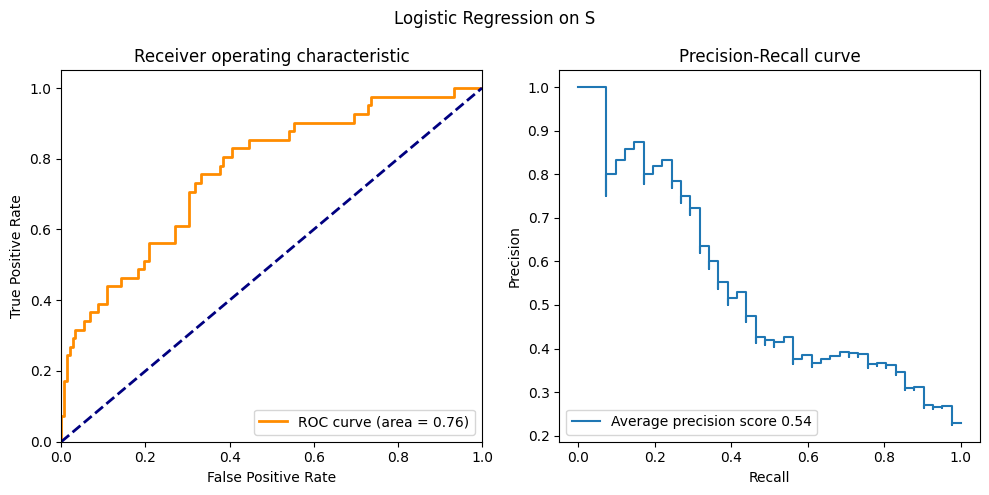

In [302]:
col = 'S'
name = f'Logistic Regression on {col}'
model = res_lr[col]['model_gs']
y_val = Y_val[col]
y_pred = model.predict(X_val_tfidf.todense())
y_true = y_val
y_scores = model.predict_proba(X_val_tfidf.todense())[:,1]
print(model.best_params_)
check_performance(y_true, y_pred, y_scores, name)

{'C': 10.0, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.746031746031746
Precision: 0.52
Recall: 0.2653061224489796
F1-score: 0.35135135135135137

Confusion Matrix
[[128  12]
 [ 36  13]]


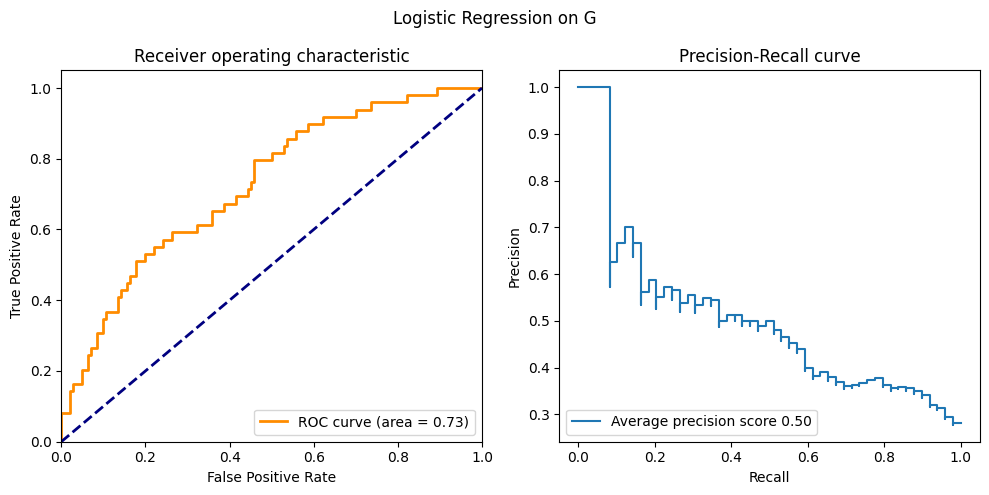

In [304]:
col = 'G'
name = f'Logistic Regression on {col}'
model = res_lr[col]['model_gs']
y_val = Y_val[col]
y_pred = model.predict(X_val_tfidf.todense())
y_true = y_val
y_scores = model.predict_proba(X_val_tfidf.todense())[:,1]
print(model.best_params_)
check_performance(y_true, y_pred, y_scores, name)

{'C': 10, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf'}
Accuracy: 0.783068783068783
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Confusion Matrix
[[148   0]
 [ 41   0]]


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


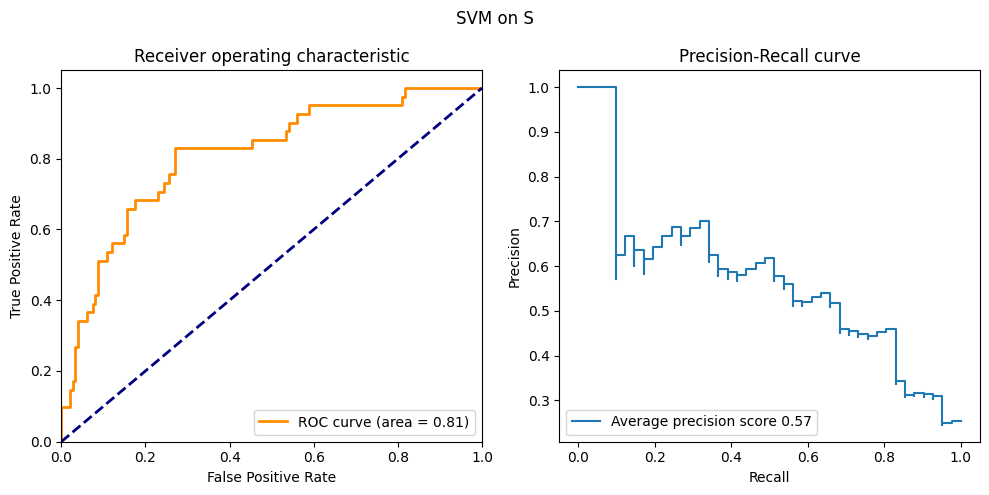

In [305]:
col = 'S'
name = f'SVM on {col}'
model = res_sv[col]['model_gs']
y_val = Y_val[col]
y_pred = model.predict(X_val_tfidf.todense())
y_true = y_val
y_scores = model.predict_proba(X_val_tfidf.todense())[:,1]
print(model.best_params_)
check_performance(y_true, y_pred, y_scores, name)

{'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
Accuracy: 0.7513227513227513
Precision: 1.0
Recall: 0.04081632653061224
F1-score: 0.07843137254901959

Confusion Matrix
[[140   0]
 [ 47   2]]


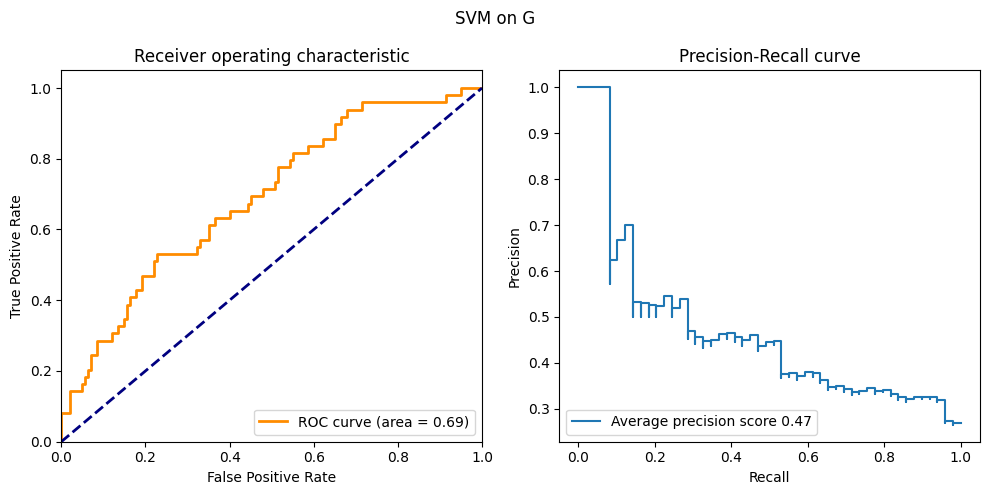

In [306]:
col = 'G'
name = f'SVM on {col}'
model = res_sv[col]['model_gs']
y_val = Y_val[col]
y_pred = model.predict(X_val_tfidf.todense())
y_true = y_val
y_scores = model.predict_proba(X_val_tfidf.todense())[:,1]
print(model.best_params_)
check_performance(y_true, y_pred, y_scores, name)

{'class_weight': 'balanced', 'max_depth': 90.0, 'min_samples_leaf': 5, 'n_estimators': 30}
Accuracy: 0.783068783068783
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Confusion Matrix
[[148   0]
 [ 41   0]]


C:\ProgramData\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


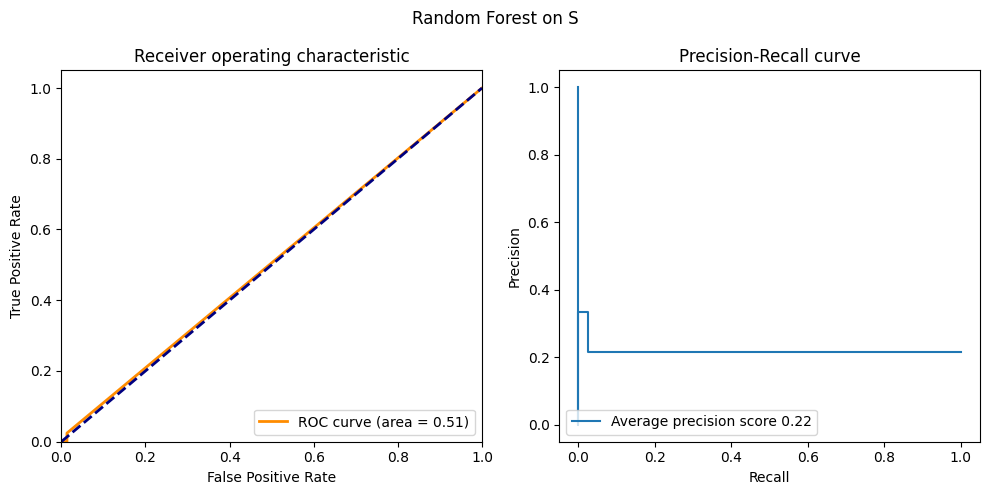

In [307]:
col = 'S'
name = f'Random Forest on {col}'
model = res_rf[col]['model_gs']
y_val = Y_val[col]
y_pred = model.predict(X_val_tfidf.todense())
y_true = y_val
y_scores = model.predict_proba(X_val_tfidf.todense())[:,1]
print(model.best_params_)
check_performance(y_true, y_pred, y_scores, name)

{'class_weight': 'balanced', 'max_depth': 40.0, 'min_samples_leaf': 5, 'n_estimators': 20}
Accuracy: 0.7354497354497355
Precision: 0.0
Recall: 0.0
F1-score: 0.0

Confusion Matrix
[[139   1]
 [ 49   0]]


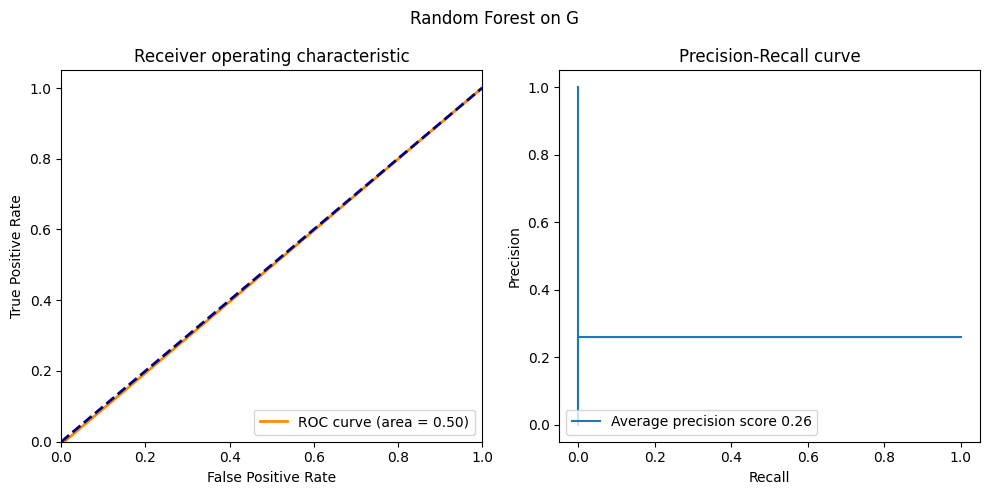

In [310]:
col = 'G'
name = f'Random Forest on {col}'
model = res_rf[col]['model_gs']
y_val = Y_val[col]
y_pred = model.predict(X_val_tfidf)
y_true = y_val
y_scores = model.predict_proba(X_val_tfidf)[:,1]
print(model.best_params_)
check_performance(y_true, y_pred, y_scores, name)